In [1]:
#!pip install pandas
#!pip install matplotlib

# Importamos librerías
import zipfile
import pandas as pd
import numpy as np
from io import BytesIO
from matplotlib import pyplot as plt

In [2]:
file_path = '/home/maria/Escritorio/TI/DatosSinapsisArtificial'

In [3]:
def zip_to_dataframe(file_path, file_name, names):
    file_path_zip = f'{file_path}/{file_name}.zip'
    file_name_txt = f'{file_name}.txt'
    with zipfile.ZipFile(file_path_zip) as thezip:
        with thezip.open(file_name_txt, mode='r') as thefile:
            data = thefile.read()
            return pd.read_csv(BytesIO(data), sep = '\t', index_col = False, names = names, skiprows=range(3), decimal = ',')

### Análisis TrozoC

In [4]:
filename = 'TrozoC'
names = ['LP','VD']
df_trozo_c = zip_to_dataframe(file_path, filename, names)

In [151]:
print('Number of channels = ', len(df_trozo_c.columns)) # 2
print('Number of samples per channel = ', len(df_trozo_c)) # 19847700
df_trozo_c.head()

Number of channels =  2
Number of samples per channel =  19847700


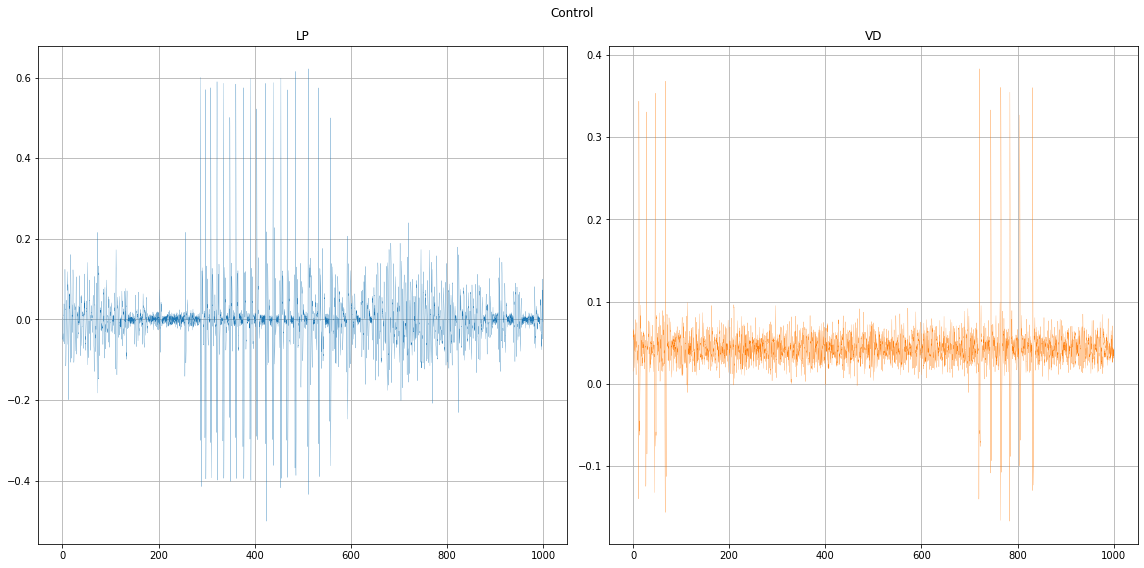

In [16]:
n = 10000
dt = 0.1
t = np.arange(0, n*dt, dt)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 8)
fig.suptitle('Control')

ax1.grid(True)
ax1.plot(t,df_trozo_c['LP'].iloc[:n],lw=0.2)
ax1.set_title("LP")

ax2.plot(t,df_trozo_c['VD'].iloc[:n],'tab:orange',lw=0.2)
ax2.set_title("VD")
ax2.grid(True)

fig.tight_layout()

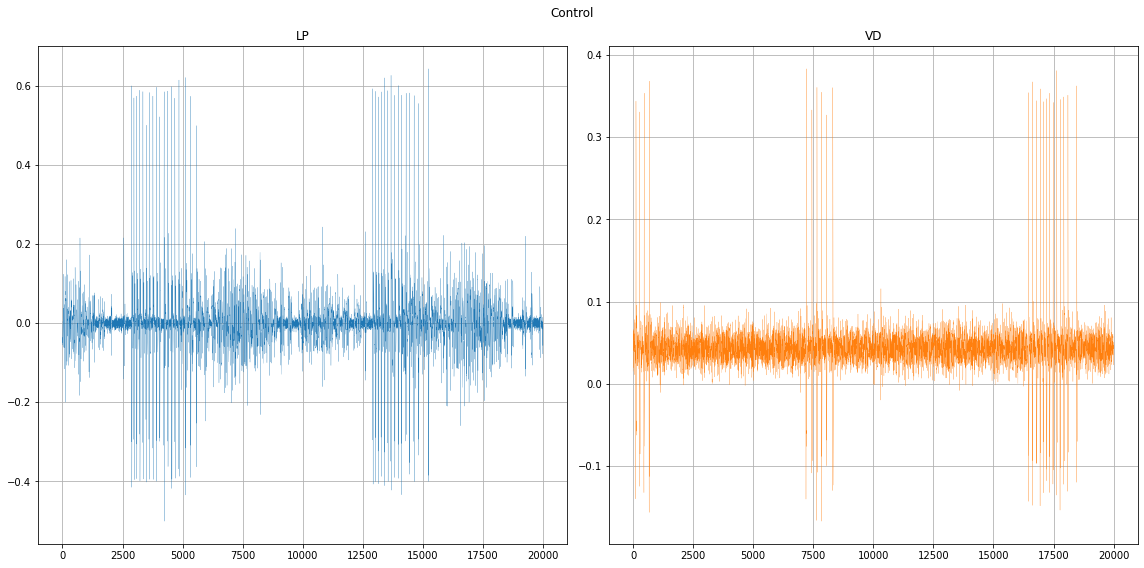

In [111]:
n = 20000

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 8)
fig.suptitle('Control')

ax1.plot(df_trozo_c['LP'].iloc[:n],lw=0.2)
ax1.set_title("LP")
ax1.grid(True)

ax2.plot(df_trozo_c['VD'].iloc[:n],'tab:orange',lw=0.2)
ax2.set_title("VD")
ax2.grid(True)

fig.tight_layout()

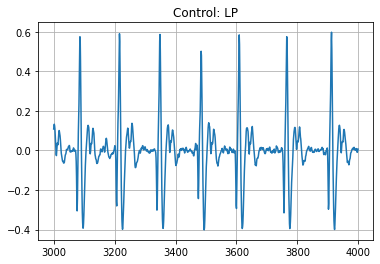

In [10]:
# Realizamos zoom a aquellos tiempos en los que se aprecian claramente los spikes
i = 3000
f = 4000

plt.plot(df_trozo_c['LP'].iloc[i:f])
plt.title("Control: LP")
plt.grid(True)

Definir umbral para detectar outlier (i.e. spikes), realizar un kernel gaussiano (repasar transparencias el profe comentó algo de eso)

### Particionado de los datos

Como la dimensión de la muestra es muy alta (19847700), vamos a realizar una partición de la misma para no abusar del coste computacional.

In [18]:
partition_trozo_c= np.array_split(df_trozo_c, 100)
umbral_lp = 0.4
spikes_by_partition = [partition[partition.loc[:,'LP'].abs() > umbral_lp]['LP'] for partition in partition_trozo_c]
n_spikes_by_partition = [len(spikes) for spikes in spikes_by_partition]
print(n_spikes_by_partition)

## Detección de Spikes

### Utilizando método estadístico

In [145]:
df_trozo_c.describe()

,LP,VD
count,1.984770e+07,1.984770e+07
mean,-2.253853e-08,4.385849e-02
std,8.214042e-02,3.287948e-02
min,-7.101440e-01,-2.170715e+00
25%,-2.288800e-02,3.295900e-02
50%,3.050000e-04,4.364000e-02
75%,2.410900e-02,5.401600e-02
max,9.344480e-01,1.351624e+00


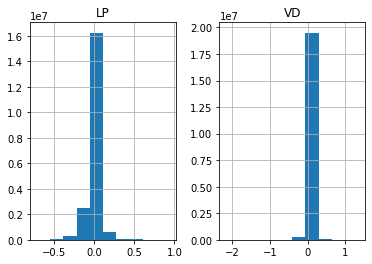

In [152]:
histogram = df_trozo_c.hist()
plt.show()

In [147]:
def get_fences(series, q1,q3):
    q1 = series.quantile(q1)
    q3 = series.quantile(q3)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    return fence_low,fence_high

In [153]:
fence_low,fence_high = get_fences(df_trozo_c['LP'],0.25,0.75)
print('Umbrales utilizando (q1=0.25,q2=0.75) = ',fence_low,fence_high)
fence_low,fence_high = get_fences(df_trozo_c['LP'],0.1,0.9)
print('Umbrales utilizando (q1=0.1,q2=0.9)',fence_low,fence_high)

Umbrales utilizando (q1=0.25,q2=0.75) =  -0.09338349999999998 0.09460449999999998
Umbrales utilizando (q1=0.1,q2=0.9) -0.275575 0.276185


Se necesita utilizar quartiles próximos a los extremos para encontrar spikes reales, ya que se trata de una muestra desvalanceada.

A partir de los resultados obtenidos y contrastandolo con las gráficas, podemos suponer que se trata de un spike si la señal toma un valor superior a 0.3 en valor absoluto.

### Discretización

In [165]:
umbral = 0.3
c_lp_discreto = np.where(abs(df_trozo_c['LP']) >= umbral, 1,0)
c_vd_discreto = np.where(abs(df_trozo_c['VD']) >= umbral, 1,0)
df_c_discreto = pd.DataFrame({'LP':c_lp_discreto, 'VD':c_vd_discreto})
print('Número de Spikes Control LP =', np.sum(c_lp_discreto) )
print('Número de Spikes Control VD =', np.sum(c_vd_discreto) )

Número de Spikes Control LP = 363558
Número de Spikes Control VD = 77194


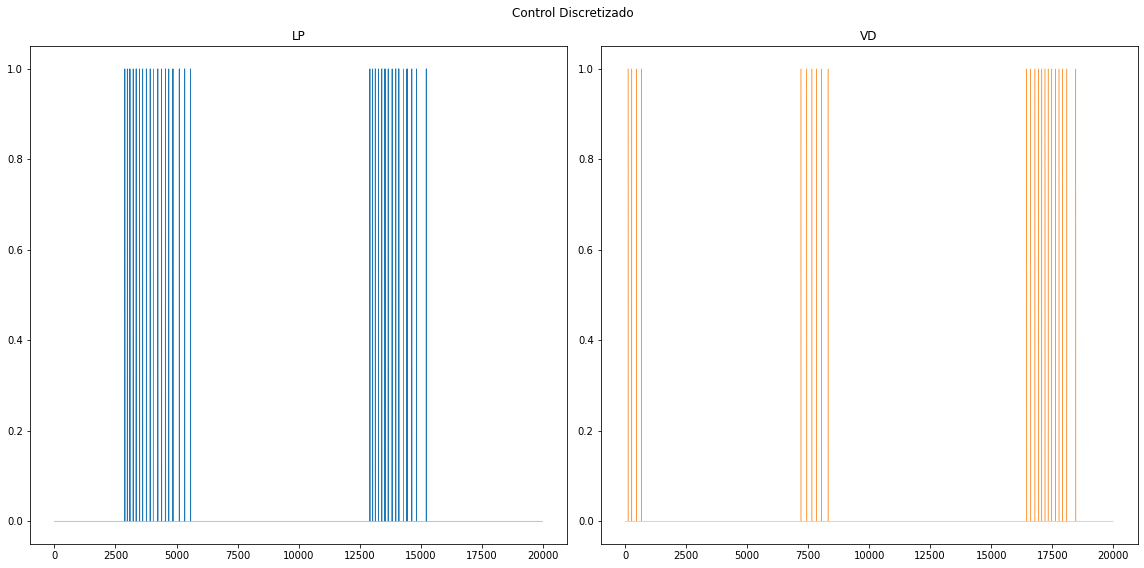

In [166]:
n = 20000

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 8)
fig.suptitle('Control Discretizado')

ax1.plot(df_c_discreto['LP'].iloc[:n],lw=0.4)
ax1.set_title("LP")

ax2.plot(df_c_discreto['VD'].iloc[:n],'tab:orange',lw=0.4)
ax2.set_title("VD")

fig.tight_layout()

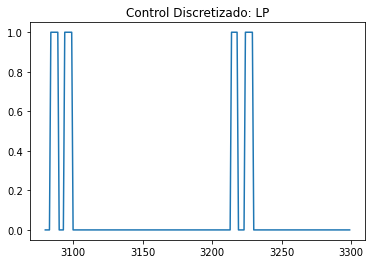

In [175]:
i = 3080
f = 3300
plt.plot(df_c_discreto['LP'].iloc[i:f])
plt.title("Control Discretizado: LP")
plt.show()

En esta gráfica se puede apreciar que nuestra discretización le ha dado valores de 1 a aquellos instantes de tiempo que pertenecen a un único spike. Por tanto, hay que realizar una función que controle el isntante en que empieza a disparar el spike y el instante en el que termina. 

In [195]:
def get_ini_fin_spikes(series, distancia):
    spike = False
    start_spike = 0
    end_spike = 0
    spikes_idx = []
    for i in series.index:
        if series[i] == 1 and spike == False:
            spike = True
            start_spike = i
        if series[i] == 0 and spike == True:
            if (i- start_spike) >= distancia:
                end_spike = i
                spike = False
                spikes_idx.append([start_spike,end_spike])

    return np.asarray(spikes_idx)     

In [201]:
ini_fin_spikes = get_ini_fin_spikes(df_c_discreto['LP'], 4)

In [ ]:
real_spikes = np.zeros(shape=(df_c_discreto.shape[0],))
for spike in ini_fin_spikes:
    real_spikes[np.median(spike)] = 1
df_c_discreto['LP_spike'] = real_spikes

In [ ]:
i = 3080
f = 3300
plt.plot(df_c_discreto['LP_spikes'].iloc[i:f])
plt.title("Control Discretizado: LP")
plt.show()

## Tamaño de la ventana

A continuación vamos a definir un tamaño de ventana de modo que exista un único spike por ventana, maximizando al mismo tiempo el tamaño de esta.